# Receiver Operating Characteristic (ROC) with cross validation on Iris

In this notebook we find an example of Receiver Operating Characteristic (ROC) Curves.

An ROC curve represents the discriminative ability of a binary classification in a graphical plot. In an ROC curve the true positive rate of the binary classification on the Y axis is plotted against the false positive rate of the binary classification on the X axis.

A method, known as K-fold cross-validation, can be used to visualize the confidence of the ROC curve. The idea behind K-fold cross-validation is to split up the Iris dataset into K folds. For each of the K folds, one fold is kept seperated, and a classifier is trained on the remaining folds. Then this classifier is evaluated on the seperated fold. The K-fold cross-validation method yields K classifiers with K validations. The variance of the curves roughly shows how the classifier output is affected by the changes in the train data, and gives an indication of the confidence intervals.

We took the example below from the [SKLearn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py).

In [1]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

total_labels = np.array([])
total_probas = np.array([])

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    total_labels = np.concatenate([total_labels, y[test]], axis=None)
    total_probas = np.concatenate([total_probas, probas_[:, 1]], axis=None)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

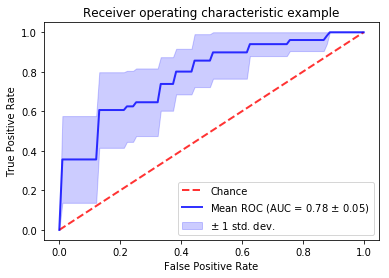

In [2]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ROC confidence intervals with pyroc and cross validation

Our next goal is to create ROC confidence intervals (1 sigma) for the cross validation predictions. In the previous example we performed a K-fold cross validation, yielding K validation on K disjoint folds. We create an ROC curve for all K-fold validations together. Next we plot the confidence interval for 1-sigma. As p-value we should take p = 1 - (0.68 + 0.32 / 2) = 1 - 0.84 = 0.16. We compare the results with the SKLearn results from the example above.

In [3]:
import pyroc

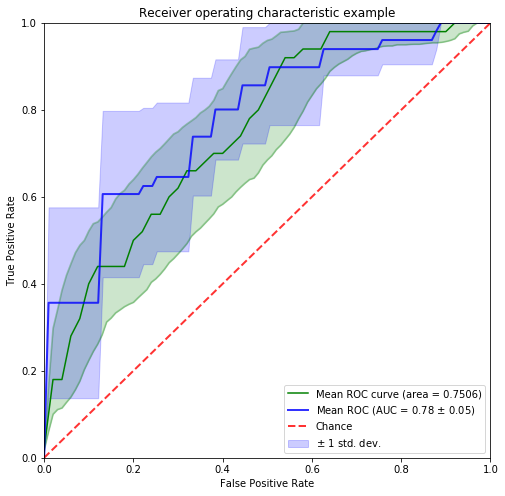

In [4]:
roc = pyroc.ROC(total_labels, total_probas)

fig, ax = plt.subplots(figsize=(8, 8))
roc.plot(
    x_label='False Positive Rate',
    y_label='True Positive Rate',
    title='Receiver operating characteristic example',
    label=f'Mean ROC curve (area = {roc.auc})',
    color='green',
    bootstrap=True,
    p_value=0.16,
    ax=ax)

ax.plot(mean_fpr, mean_tpr, color='b',
    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
    lw=2, alpha=.8)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
    label=r'$\pm$ 1 std. dev.')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.legend(loc="lower right")